# Deep Learning Challenge

<span style="color:green">**Réalisé par Adama Nana et Issam Belhorma**</span>

Nous avons identifier dès le départ trois modèles de réseaux de neurones. 



1.   **CNN** : Ce modèle est spécialement conçu pour les données de vision telles que les images et est sans doutes l'un des plus adaptés aux tâches de classification d'images.
2.   **Fine-tuning** : Cette option peut etre intéressante mais peut aussi etre inadapté pour un petit problème comme le notre. Mais nous avons quand meme testé du fine-tuning. Nous avons choisi ResNet50.
3. **Auto-Encodeur** : L'apprentissage non suppervisé peut etre un moyen efficace. Elle permet d'apprendre les caractéristiques des images du dataset. Utiliser un auto-encodeur comme pré-tache est un bon moyen de booster les performances d'un modèle.
4. **Keras Tuner** : Nous avons utilisé la bibliothèque keras tuner et plus précisément la class BayesianOptimization pour la recherche des meilleurs hyperparamètres pour notre modèle. Cette class donne de très bon résultats mais le temps d'exécution est aussi très grand.

<span style="color:red">**Nous avons donc, à la fin, fait un benchmarking des 3 modèles pour en sélectionner le plus performant**</span>

<span style="color:red">**Dans ce NoteBook, nous avons entrainé nos modèles sur quelques epochs. Le modèle qui est fourni à été entrainé sur plus d'epochs et est beaucoup plus performant**</span>

<span style="color:blue">**Nous avons atteint un accuracy de 97% avec notre modèle sur le dataset de test.**</span>

# Imports

In [75]:
import os
import cv2
import datetime
import tqdm as tqdm
import tensorflow
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Reshape, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import Dense, Conv2DTranspose, LeakyReLU, Activation
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Rescaling
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

#data augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, RandomBrightness

# Data loading and preprocessing

<span style="color:red">Dans le cas où ce NoteBook sera ré-exécuté, il faudra évidemment l'exécuter dans un dossier qui comptient les fichiers ***train.csv*** et ***valid.csv*** ainsi que le contenu de l'archive ***Data_Train_Valid.zip.*** Nous avons choisi 5000 images parmis les 25000 du dataset de validation pour constituer une base de test.</span>

In [76]:
classes = ["basket","eye","binoculars","rabbit","hand"]
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [77]:
tmp_train = train.to_numpy()
X = []
y = []
for image in tqdm.tqdm(tmp_train) :
    X.append(np.asarray(Image.open('images/'+image[1])))
    y.append(image[2])
    
Xtrain = np.asarray(X)
Ytrain = np.asarray(y)

100%|██████████| 75000/75000 [00:13<00:00, 5385.98it/s]


In [78]:
tmp_test = valid.to_numpy()
X = []
y = []
for image in tqdm.tqdm(tmp_test) :
    X.append(np.asarray(Image.open('images/'+image[1])))
    y.append(image[2])
    
Xtest = np.asarray(X)
Ytest = np.asarray(y)

100%|██████████| 25000/25000 [00:06<00:00, 3975.79it/s]


In [79]:
xtrain = (np.expand_dims(Xtrain, axis=-1)).astype('float32') / 255.
ytrain = to_categorical(Ytrain, num_classes=5)
x_valid, x_test, y_valid, y_test = train_test_split(Xtest, Ytest, test_size=0.20, random_state=42)
xvalid = (np.expand_dims(x_valid, axis=-1)).astype('float32') / 255.
yvalid = to_categorical(y_valid)
xtest  = (np.expand_dims(x_test, axis=-1)).astype('float32') / 255.
ytest  = to_categorical(y_test)

In [80]:
print(f"Base de données d'entrainement : {xtrain.shape} {ytrain.shape}")
print(f"Base de données de validation  : {xvalid.shape} {yvalid.shape}")
print(f"Base de données de test        : {xtest.shape} {ytest.shape}")

Base de données d'entrainement : (75000, 28, 28, 1) (75000, 5)
Base de données de validation  : (20000, 28, 28, 1) (20000, 5)
Base de données de test        : (5000, 28, 28, 1) (5000, 5)


In [81]:
def classe(vect) :
    name = ''
    if vect[0] == 1. :
        name = 'basket'
    elif vect[1] == 1. :
        name = 'eye'
    elif vect[2] == 1. :
        name = 'binoculars'
    elif vect[3] == 1. :
        name = 'rabbit'
    elif vect[4] == 1. :
        name = 'hand'
    return name

In [82]:
# Affichage des images dans une grille
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()
for i in np.arange(0, 25):
    index = np.random.randint(0, len(xtrain))
    image = xtrain[index][:, :, 0]
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(classe(ytrain[index]))
    axes[i].axis('off')

**Il est important de vérifier que toutes les 5 classes sont bien représentées dans notre dataset. Si on a une ou plusieurs classes sous représentées, cela poserait problème. Donc nous allons afficher la répartition des classes dans l'ensemble de données de test et dans l'ensemble de données d'entrainement.**

In [83]:
def compteur(tab, index) :
    cmp = 0
    for value in tab :
        if value[index]==1 :
            cmp = cmp+1
    return cmp

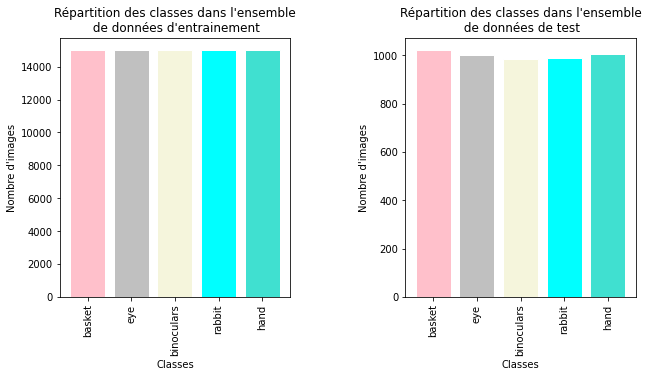

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # creates a 1x2 grid of subplots
fig.subplots_adjust(left=0.0, right=1, bottom=0.0, top=0.9, wspace=0.0, hspace=0.0)
plt.subplots_adjust(wspace=0.5)

# First plot
etiquettes    = ["basket","eye","binoculars","rabbit","hand"]
liste_valeurs = [compteur(ytrain, 0), compteur(ytrain, 1), compteur(ytrain, 2), compteur(ytrain, 3), compteur(ytrain, 4)]
axes[0].bar(etiquettes, liste_valeurs, color=['pink', 'silver', 'beige', 'cyan', 'turquoise'], edgecolor="white")
axes[0].set_title("Répartition des classes dans l'ensemble\n de données d'entrainement")
axes[0].set_ylabel('Nombre d\'images')
axes[0].set_xlabel('Classes')
axes[0].xaxis.set_ticks(etiquettes)
axes[0].set_xticklabels(etiquettes, rotation=90)

# Second plot
etiquettes    = ["basket","eye","binoculars","rabbit","hand"]
liste_valeurs = [compteur(ytest, 0), compteur(ytest, 1), compteur(ytest, 2), compteur(ytest, 3), compteur(ytest, 4)]
axes[1].bar(etiquettes, liste_valeurs, color=['pink', 'silver', 'beige', 'cyan', 'turquoise'], edgecolor="white")
axes[1].set_title("Répartition des classes dans l'ensemble\n de données de test")
axes[1].set_ylabel('Nombre d\'images')
axes[1].set_xlabel('Classes')
axes[1].xaxis.set_ticks(etiquettes)
axes[1].set_xticklabels(etiquettes, rotation=90)

plt.show()

# Data Augmentation 

**Il ya deux options pour faire de l'augmentation de données. Une première qui consiste à intégrer les couches de prétraitement dans le modèle et une deuxième qui consiste à appliquer les couches de prétraitement au jeu de données. Nous avons opté pour la preùmière option. Pour chacun de nos modèles, nous testerons une version sans augmentation de données et une version avec augmentation de données.**

In [85]:
data_augmentation_layer = Sequential([
    RandomBrightness(0.2,value_range=(0.5, 1.5)),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.3),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
])

# Models

In [86]:
num_epochs = 20
batch_size = 64

# Récupération de la date actuelle
now = datetime.datetime.now()

# Nom du dossier
directory_name = "saved_models_at_" + now.strftime("%Y-%m-%d")
print(directory_name)

saved_models_at_2023-01-31


In [87]:
# Création du dossier s'il n'existe pas
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

## I. CNN

## I.1. Sans augmentation de données

In [88]:
def CNN_MODEL(data_aug) :
    model = Sequential()
    if data_aug :
        # Add the data augmentation layer.
        data_augmentation_layer
    
    model.add(Input((28,28,1)))
    model.add(Rescaling(1./255, input_shape=(28,28,1)))
    
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units=5, activation='softmax'))
    
    return model

In [89]:
# Initialiser des callbacks pour l'arrêt anticipé et la régularisation

# EarlyStopping nous permettra d'arrèter l'entrainement si l'accuracy du 
# model sur le jeu de données de validation cesse de s'améliorer pendant 10 epochs 
early_stop = EarlyStopping(monitor='val_accuracy', patience=25)

# ReduceLROnPlateau surveille la valeur de l'accuracy sur le jeu de données de validation
# Si elle ne s'améliore pas pendant 10 epochs, on réduit le taux d'apprentissage
# par un facteur de 0.2. Cette m"thode aide le model à ne pas rester coincé dans 
# un minimum local et à continuer à améliorer ses performances
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=25, min_lr=1e-6)

# checkpoint sert ici à enregister le modèle à chaque epoch si ses performances 
# ont augmentées par rapport à l'epoch précédente. On ne sauvegarde que les poids du model
checkpoint = ModelCheckpoint(filepath='CNN_Without_Data_Aug.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy',mode='max')

In [90]:
model = CNN_MODEL(data_aug=False)

In [91]:
keras.utils.plot_model(model, show_shapes=True)

In [92]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
cnn_without_data_aug_history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=num_epochs, validation_data=(xvalid, yvalid), callbacks=[checkpoint])

Epoch 1/20
1172/1172 [==============================] - 32s 26ms/step - loss: 0.3054 - accuracy: 0.9037 - val_loss: 0.3049 - val_accuracy: 0.8879
Epoch 2/20
1172/1172 [==============================] - 31s 26ms/step - loss: 0.1675 - accuracy: 0.9447 - val_loss: 0.1477 - val_accuracy: 0.9506
Epoch 3/20
1172/1172 [==============================] - 29s 25ms/step - loss: 0.1411 - accuracy: 0.9530 - val_loss: 0.1952 - val_accuracy: 0.9357
Epoch 4/20
1172/1172 [==============================] - 30s 25ms/step - loss: 0.1254 - accuracy: 0.9587 - val_loss: 0.1760 - val_accuracy: 0.9436
Epoch 5/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.1156 - accuracy: 0.9608 - val_loss: 0.2086 - val_accuracy: 0.9359
Epoch 6/20
1172/1172 [==============================] - 30s 25ms/step - loss: 0.1049 - accuracy: 0.9645 - val_loss: 0.1342 - val_accuracy: 0.9570
Epoch 7/20
1172/1172 [==============================] - 30s 25ms/step - loss: 0.0938 - accuracy: 0.9680 - val_loss: 0.1678 -

In [94]:
cnn_without_data_aug_score = model.evaluate(xtest, ytest)
print(f"Test Score    : {cnn_without_data_aug_score[0]}")
print(f"Test Accuracy : {cnn_without_data_aug_score[1]}")

157/157 [==============================] - 1s 6ms/step - loss: 0.2425 - accuracy: 0.9564
Test Score    : 0.24252353608608246
Test Accuracy : 0.9563999772071838


In [95]:
accuracy     = cnn_without_data_aug_history.history['accuracy']
val_accuracy = cnn_without_data_aug_history.history['val_accuracy']
loss         = cnn_without_data_aug_history.history['loss']
val_loss     = cnn_without_data_aug_history.history['val_loss']
epochs       = range(len(accuracy))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'o-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'o-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [96]:
model.save(f"{directory_name}/CNN_Without_Data_Aug.h5")

## I.2. Avec augmentation de données

In [97]:
model = CNN_MODEL(data_aug=True)

In [98]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
checkpoint = ModelCheckpoint(filepath='CNN_With_Data_Aug.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy',mode='max')

In [100]:
cnn_with_data_aug_history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=num_epochs, validation_data=(xvalid, yvalid), callbacks=[checkpoint])

Epoch 1/20
1172/1172 [==============================] - 31s 26ms/step - loss: 0.3045 - accuracy: 0.9060 - val_loss: 0.2404 - val_accuracy: 0.9197
Epoch 2/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.1666 - accuracy: 0.9445 - val_loss: 0.1767 - val_accuracy: 0.9427
Epoch 3/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.1417 - accuracy: 0.9529 - val_loss: 0.1540 - val_accuracy: 0.9471
Epoch 4/20
1172/1172 [==============================] - 30s 25ms/step - loss: 0.1266 - accuracy: 0.9577 - val_loss: 0.1478 - val_accuracy: 0.9553
Epoch 5/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.1163 - accuracy: 0.9609 - val_loss: 0.1458 - val_accuracy: 0.9546
Epoch 6/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.1002 - accuracy: 0.9659 - val_loss: 0.1571 - val_accuracy: 0.9498
Epoch 7/20
1172/1172 [==============================] - 30s 26ms/step - loss: 0.0938 - accuracy: 0.9682 - val_loss: 0.1383 -

In [101]:
cnn_with_data_aug_score = model.evaluate(xtest, ytest)
print(f"Test Score    : {cnn_with_data_aug_score[0]}")
print(f"Test Accuracy : {cnn_with_data_aug_score[1]}")

157/157 [==============================] - 1s 6ms/step - loss: 0.2259 - accuracy: 0.9572
Test Score    : 0.22589272260665894
Test Accuracy : 0.9571999907493591


In [102]:
print("Avant l'augmentation de données")
print(f"Test loss     : {cnn_without_data_aug_score[1]}")
print(f"Test accuracy : {cnn_without_data_aug_score[1]}")
print()
print("Après l'augmentation de données")
print(f"Test loss     : {cnn_with_data_aug_score[0]}")
print(f"Test accuracy : {cnn_with_data_aug_score[1]}")

Avant l'augmentation de données
Test loss     : 0.9563999772071838
Test accuracy : 0.9563999772071838

Après l'augmentation de données
Test loss     : 0.22589272260665894
Test accuracy : 0.9571999907493591


In [103]:
model.save(f"{directory_name}/CNN_With_Data_Aug.h5")

## II. Auto-Encodeur

Il peut être pertinent d'utiliser un auto-encodeur dans une tâche de classification et ce, pour plusieurs raisons que nous avons découverts dans la littérature.

Les auto-encodeurs peuvent aider à réduire la dimensionnalité de l'espace de représentation des images, ce qui peut améliorer les performances de la classification et réduire les coûts de calcul.

Les auto-encodeurs peuvent apprendre des représentations plus pertinentes pour la tâche de classification en apprenant à reproduire les caractéristiques les plus importantes des images.

En utilisant des couches plus profondes dans le réseau, les auto-encodeurs peuvent aider à séparer les caractéristiques de l'image en des composantes plus simples et plus significatives pour la tâche de classification.

Les auto-encodeurs peuvent aider à réduire le surapprentissage en apprenant une représentation plus générale de l'ensemble de données.

Initialisation des poids : Les poids appris par l'auto-encodeur peuvent être utilisés pour initialiser le modèle final, ce qui peut améliorer les performances de la classification.

L'image ci-dessous indique l'idée que nous avons voulu mettre en pratique.

!["Self supervised as pre-text task"](auto-encodeur.png)

In [104]:
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 5

In [105]:
# Comme il s'agit ici d'un modèle non supervisé, nous pouvons l'entrainer sur tout le dataset (y compris le dataset de test)
train_X,valid_X,train_ground,valid_ground = train_test_split(np.concatenate((xtrain, xvalid, xtest), axis=0),
                                                             np.concatenate((xtrain, xvalid, xtest), axis=0),
                                                             test_size=0.2,
                                                             random_state=13)

In [106]:
def encoder(input_img, data_aug):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    if data_aug :
        data_augmentation_layer
        
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [107]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

## II.1. Sans augmentation de données

In [108]:
autoencoder = Model(input_img, decoder(encoder(input_img, data_aug=False)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [109]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_50 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_51 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)       0   

In [110]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=num_epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/20
1250/1250 [==============================] - 24s 17ms/step - loss: 0.0264 - val_loss: 0.0162
Epoch 2/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 3/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 4/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 5/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/20
1250/1250 [==============================] - 21s 17m

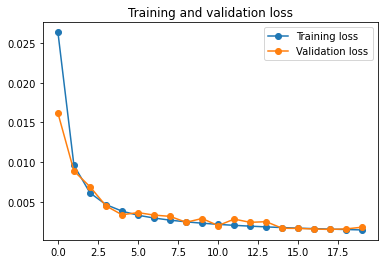

In [111]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [112]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [113]:
encode = encoder(input_img, False)
full_model = Model(input_img,fc(encode))

In [114]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [115]:
autoencoder.get_weights()[0][1]

array([[[ 1.20313905e-01,  1.04397751e-01,  2.73019820e-01,
         -3.83338742e-02,  7.01323301e-02, -2.11523220e-01,
          3.96094285e-04, -1.44752190e-01,  3.33967153e-03,
          1.69830974e-02,  2.14649573e-01,  1.73482418e-01,
         -7.24866148e-03,  3.22500691e-02,  1.18382789e-01,
         -2.02701762e-01,  2.35713586e-01, -2.11117581e-01,
          1.04480028e-01,  2.50342518e-01, -9.19143334e-02,
         -2.48958945e-01, -3.67770381e-02,  1.38817042e-01,
         -2.45362967e-02, -5.73315360e-02, -1.75937131e-01,
         -1.71218827e-01,  2.97787990e-02, -4.43680972e-01,
         -1.32833377e-01, -2.40010366e-01]],

       [[-2.97790676e-01, -5.32950200e-02,  1.45531386e-01,
          3.22121978e-01, -1.94664955e-01, -2.64936358e-01,
         -1.64026946e-01, -4.92846251e-01, -1.58126846e-01,
         -9.26758796e-02, -2.43141055e-01,  6.89413771e-02,
          2.19037548e-01,  9.55656543e-02, -9.34602544e-02,
          9.73891392e-02, -3.03044081e-01, -3.90015692

In [116]:
full_model.get_weights()[0][1]

array([[[ 1.20313905e-01,  1.04397751e-01,  2.73019820e-01,
         -3.83338742e-02,  7.01323301e-02, -2.11523220e-01,
          3.96094285e-04, -1.44752190e-01,  3.33967153e-03,
          1.69830974e-02,  2.14649573e-01,  1.73482418e-01,
         -7.24866148e-03,  3.22500691e-02,  1.18382789e-01,
         -2.02701762e-01,  2.35713586e-01, -2.11117581e-01,
          1.04480028e-01,  2.50342518e-01, -9.19143334e-02,
         -2.48958945e-01, -3.67770381e-02,  1.38817042e-01,
         -2.45362967e-02, -5.73315360e-02, -1.75937131e-01,
         -1.71218827e-01,  2.97787990e-02, -4.43680972e-01,
         -1.32833377e-01, -2.40010366e-01]],

       [[-2.97790676e-01, -5.32950200e-02,  1.45531386e-01,
          3.22121978e-01, -1.94664955e-01, -2.64936358e-01,
         -1.64026946e-01, -4.92846251e-01, -1.58126846e-01,
         -9.26758796e-02, -2.43141055e-01,  6.89413771e-02,
          2.19037548e-01,  9.55656543e-02, -9.34602544e-02,
          9.73891392e-02, -3.03044081e-01, -3.90015692

In [117]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [118]:
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [119]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_64 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_65 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 32)       0   

In [120]:
checkpoint = ModelCheckpoint(filepath='AutoEncodeur_Without_data_aug.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy',mode='max')

In [121]:
autoencodeur_without_data_aug_history = full_model.fit(xtrain, ytrain, batch_size=64,epochs=num_epochs,verbose=1,validation_data=(xvalid, yvalid))

Epoch 1/20
1172/1172 [==============================] - 9s 7ms/step - loss: 0.3711 - accuracy: 0.8862 - val_loss: 0.2597 - val_accuracy: 0.9155
Epoch 2/20
1172/1172 [==============================] - 9s 7ms/step - loss: 0.2291 - accuracy: 0.9232 - val_loss: 0.2480 - val_accuracy: 0.9150
Epoch 3/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1940 - accuracy: 0.9344 - val_loss: 0.2384 - val_accuracy: 0.9223
Epoch 4/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1741 - accuracy: 0.9397 - val_loss: 0.2459 - val_accuracy: 0.9240
Epoch 5/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1519 - accuracy: 0.9469 - val_loss: 0.2379 - val_accuracy: 0.9232
Epoch 6/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1407 - accuracy: 0.9510 - val_loss: 0.2562 - val_accuracy: 0.9246
Epoch 7/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1268 - accuracy: 0.9557 - val_loss: 0.2583 - val_accuracy:

In [122]:
full_model.save(f"{directory_name}/AutoEncodeur_Without_data_aug.h5")

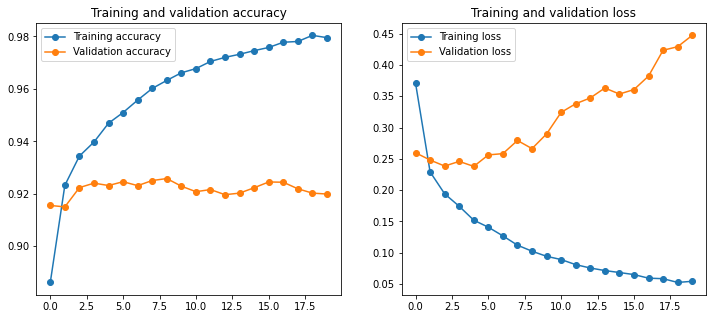

In [123]:
accuracy     = autoencodeur_without_data_aug_history.history['accuracy']
val_accuracy = autoencodeur_without_data_aug_history.history['val_accuracy']
loss         = autoencodeur_without_data_aug_history.history['loss']
val_loss     = autoencodeur_without_data_aug_history.history['val_loss']
epochs       = range(len(accuracy))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'o-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'o-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [124]:
autoencodeur_without_data_aug_score = full_model.evaluate(xtest, ytest, verbose=0)
print('Test loss    :', autoencodeur_without_data_aug_score[0])
print('Test accuracy:', autoencodeur_without_data_aug_score[1])

Test loss    : 0.405273973941803
Test accuracy: 0.9247999787330627


## II.2. Avec augmentation de données

In [125]:
autoencoder = Model(input_img, decoder(encoder(input_img, data_aug=True)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [126]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=num_epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/20
1250/1250 [==============================] - 25s 18ms/step - loss: 0.0274 - val_loss: 0.0175
Epoch 2/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 3/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 4/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 6/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 8/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/20
1250/1250 [==============================] - 21s 17m

In [127]:
encode = encoder(input_img, True)
full_model = Model(input_img,fc(encode))

In [128]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [129]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [130]:
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [131]:
checkpoint = ModelCheckpoint(filepath='AutoEncodeur_With_data_aug.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy',mode='max')

In [132]:
autoencodeur_with_data_aug_history = full_model.fit(xtrain, ytrain, batch_size=64,epochs=num_epochs,verbose=1,validation_data=(xvalid, yvalid))

Epoch 1/20
1172/1172 [==============================] - 8s 6ms/step - loss: 0.3879 - accuracy: 0.8793 - val_loss: 0.2848 - val_accuracy: 0.9060
Epoch 2/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.2433 - accuracy: 0.9182 - val_loss: 0.2528 - val_accuracy: 0.9178
Epoch 3/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.2041 - accuracy: 0.9303 - val_loss: 0.2631 - val_accuracy: 0.9150
Epoch 4/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1847 - accuracy: 0.9358 - val_loss: 0.2625 - val_accuracy: 0.9159
Epoch 5/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1646 - accuracy: 0.9435 - val_loss: 0.2518 - val_accuracy: 0.9205
Epoch 6/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1478 - accuracy: 0.9482 - val_loss: 0.2936 - val_accuracy: 0.9097
Epoch 7/20
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1369 - accuracy: 0.9514 - val_loss: 0.3029 - val_accuracy:

In [133]:
autoencodeur_with_data_aug_score = full_model.evaluate(xtest, ytest, verbose=0)
print('Test loss    :', autoencodeur_with_data_aug_score[0])
print('Test accuracy:', autoencodeur_with_data_aug_score[1])

Test loss    : 0.36424195766448975
Test accuracy: 0.9246000051498413


In [134]:
full_model.save(f"{directory_name}/AutoEncodeur_With_data_aug.h5")

## III. Fine-tuning (ResNet50)

In [135]:
# ResNet50 exige des images de shape (_,_,3)
X_train = np.repeat(xtrain, 3, axis=-1)
X_valid = np.repeat(xvalid, 3, axis=-1)
X_test  = np.repeat(xtest, 3, axis=-1)

print(f"Base de données d'entrainement : {X_train.shape} {ytrain.shape}")
print(f"Base de données de validation  : {X_valid.shape} {yvalid.shape}")
print(f"Base de données de test        : {X_test.shape} {ytest.shape}")

Base de données d'entrainement : (75000, 28, 28, 3) (75000, 5)
Base de données de validation  : (20000, 28, 28, 3) (20000, 5)
Base de données de test        : (5000, 28, 28, 3) (5000, 5)


In [136]:
def load_and_configure_model(model_name, optimizer, loss, metrics, path):
    num_classes = 5
    assert model_name == 'resnet50'
    model = ResNet50(input_tensor=Input(shape=(28, 28, 3)))
    for layer in model.layers:
        layer.trainable = False
    transfer_layer = model.get_layer('avg_pool')
    x = Dense(num_classes, activation='softmax')(transfer_layer.output)
    model = Model(inputs=model.input, outputs=x)
    model.trainable = True
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if path is not None:
        model.load_weights(path)
    return model

In [137]:
loaded_model = load_and_configure_model(
              'resnet50',
              'RMSprop',
              'categorical_crossentropy',
              ['accuracy'],
              None)

102967424/102967424 [==============================] - 1s 0us/step


In [138]:
RESNET50 = Sequential()
RESNET50.add(loaded_model)
RESNET50.add(Flatten())
RESNET50.add(Dense(5, activation='softmax'))

In [139]:
for i, layer in enumerate(RESNET50.layers) :
    print(i, layer.name, "-", layer.trainable)

0 model_5 - True
1 flatten_8 - True
2 dense_17 - True


In [140]:
RESNET50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [141]:
checkpoint = ModelCheckpoint(filepath='RESNET50_Without_data_aug.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy',mode='max')

In [142]:
RESNET50_Without_data_aug_history = RESNET50.fit(X_train, ytrain, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_valid, yvalid))

Epoch 1/20
1172/1172 [==============================] - 63s 48ms/step - loss: 0.9417 - accuracy: 0.6806 - val_loss: 0.6679 - val_accuracy: 0.7412
Epoch 2/20
1172/1172 [==============================] - 54s 46ms/step - loss: 0.5760 - accuracy: 0.7509 - val_loss: 0.5175 - val_accuracy: 0.7628
Epoch 3/20
1172/1172 [==============================] - 54s 46ms/step - loss: 0.4760 - accuracy: 0.7700 - val_loss: 0.4692 - val_accuracy: 0.7722
Epoch 4/20
1172/1172 [==============================] - 54s 46ms/step - loss: 0.4395 - accuracy: 0.8121 - val_loss: 0.4830 - val_accuracy: 0.8985
Epoch 5/20
1172/1172 [==============================] - 57s 48ms/step - loss: 0.3311 - accuracy: 0.9422 - val_loss: 0.3275 - val_accuracy: 0.9330
Epoch 6/20
1172/1172 [==============================] - 55s 47ms/step - loss: 0.2606 - accuracy: 0.9484 - val_loss: 0.2642 - val_accuracy: 0.9419
Epoch 7/20
1172/1172 [==============================] - 54s 46ms/step - loss: 0.2068 - accuracy: 0.9565 - val_loss: 0.2267 -

In [143]:
RESNET50_Without_data_aug_score = RESNET50.evaluate(X_test, ytest)
print('Test loss    :', RESNET50_Without_data_aug_score[0])
print('Test accuracy:', RESNET50_Without_data_aug_score[1])

157/157 [==============================] - 2s 16ms/step - loss: 0.1742 - accuracy: 0.9550
Test loss    : 0.17416249215602875
Test accuracy: 0.9549999833106995


In [144]:
RESNET50.save(f"{directory_name}/RESNET50_Without_data_aug.h5")

# Benchmarking

In [145]:
# Métriques de performances pour les trois modèles
model1_accuracy  = cnn_without_data_aug_score[1]
model1_precision = cnn_without_data_aug_score[0]

model2_accuracy  = cnn_with_data_aug_score[1]
model2_precision = cnn_with_data_aug_score[0]

model3_accuracy  = autoencodeur_without_data_aug_score[1]
model3_precision = autoencodeur_without_data_aug_score[0]

model4_accuracy  = autoencodeur_with_data_aug_score[1]
model4_precision = autoencodeur_with_data_aug_score[0]

#Resnet
model5_accuracy  = RESNET50_Without_data_aug_score[1] 
model5_precision = RESNET50_Without_data_aug_score[0]

model6_accuracy  = RESNET50_Without_data_aug_score[1]
model6_precision = RESNET50_Without_data_aug_score[0]

In [146]:
# Stockage des métriques dans un dataframe
data = {'Accuracy': [model1_accuracy, model2_accuracy, model3_accuracy, model4_accuracy, model5_accuracy, model6_accuracy],
        'Precision': [model1_precision, model2_precision, model3_precision, model4_precision, model5_precision, model6_precision]}
df   = pd.DataFrame(data, index=['CNN Without Data Aug', 
                                 'CNN With Data Aug', 
                                 'AutoEncoder Without Data Aug', 
                                 'AutoEncoder With Data Aug',
                                 'ResNet50 Without Data Aug',
                                 'ResNet50 With Data Aug'])

# Affichage du tableau comparatif
print(df)

                              Accuracy  Precision
CNN Without Data Aug            0.9564   0.242524
CNN With Data Aug               0.9572   0.225893
AutoEncoder Without Data Aug    0.9248   0.405274
AutoEncoder With Data Aug       0.9246   0.364242
ResNet50 Without Data Aug       0.9550   0.174162
ResNet50 With Data Aug          0.9550   0.174162


In [147]:
models    = ["CNN", "AutoEncodeur", "ResNet50"]

loss      = [model1_precision, model3_precision, model5_precision]
loss_aug  = [model2_precision, model4_precision, model6_precision]

acc       = [model1_accuracy, model3_accuracy, model5_accuracy]
acc_aug   = [model2_accuracy, model4_accuracy, model6_accuracy]

# Position sur l'axe des x pour chaque étiquette
position = np.arange(len(models))
# Largeur des barres
largeur = .35

Text(0.5, 1.0, 'Models losses with data augmentation\n and after training during 20')

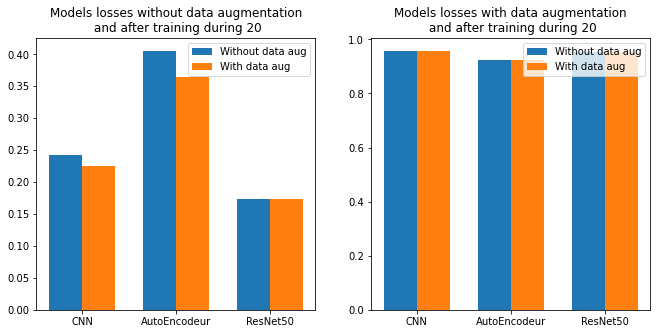

In [148]:
# Création de la figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))


# Première série de barres
r1 = ax1.bar(position - largeur/2, loss, largeur, label='Without data aug')
r2 = ax1.bar(position + largeur/2, loss_aug, largeur, label = "With data aug")

# Deuxième série de barres
r3 = ax2.bar(position - largeur/2, acc, largeur, label='Without data aug')
r4 = ax2.bar(position + largeur/2, acc_aug, largeur, label ='With data aug')

# Modification des marques sur l'axe des x et de leurs étiquettes
ax1.set_xticks(position)
ax1.set_xticklabels(models)
ax2.set_xticks(position)
ax2.set_xticklabels(models)

# Ajout de la légende
ax1.legend()
ax2.legend()

# Ajout des titres
ax1.set_title(f"Models losses without data augmentation\n and after training during {num_epochs}")
ax2.set_title(f"Models losses with data augmentation\n and after training during {num_epochs}")

**Conclusion** : Notre CNN classique a de meilleurs performances que ResNet50 et l'auto-encodeur. C'est donc ce modèle que nous avons utilisé et entrainé sur plus d'epochs. Nous avons aussi utiliser Keras Tuner dans la section suivante pour sélectioner les meilleurs hyperparamètres pour notre CNN. 

# Keras Tuner

In [149]:
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential()

    model.add(Input((28,28,1)))
    model.add(Rescaling(1./255, input_shape=(28,28,1)))

    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Choice('dropout_1', values=[0.25, 0.5, 0.75])))

    model.add(Conv2D(hp.Int('conv_3_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('conv_4_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_2', values=[0.25, 0.5, 0.75])))

    model.add(Conv2D(hp.Int('conv_5_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('conv_6_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Choice('dropout_3', values=[0.25, 0.5, 0.75])))

    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dropout(hp.Choice('dropout_4', values=[0.25, 0.5, 0.75])))
    model.add(Dense(units=5, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [150]:
tuner = BayesianOptimization(build_model, objective='val_accuracy', overwrite=True)

In [151]:
tuner.search(xtrain, ytrain, epochs=5, validation_data=(xvalid, yvalid))

Trial 10 Complete [00h 02m 23s]
val_accuracy: 0.9424999952316284

Best val_accuracy So Far: 0.9512500166893005
Total elapsed time: 00h 20m 55s


In [154]:
best_model = tuner.get_best_models(num_models=1)[0]

In [157]:
best_model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=num_epochs)

Epoch 1/20
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0752 - accuracy: 0.9732 - val_loss: 3.2773 - val_accuracy: 0.3223
Epoch 2/20
2344/2344 [==============================] - 24s 10ms/step - loss: 0.0738 - accuracy: 0.9742 - val_loss: 1.4703 - val_accuracy: 0.5891
Epoch 3/20
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0696 - accuracy: 0.9755 - val_loss: 6.3733 - val_accuracy: 0.2049
Epoch 4/20
2344/2344 [==============================] - 24s 10ms/step - loss: 0.0710 - accuracy: 0.9757 - val_loss: 0.1653 - val_accuracy: 0.9535
Epoch 5/20
2344/2344 [==============================] - 24s 10ms/step - loss: 0.0671 - accuracy: 0.9759 - val_loss: 0.2005 - val_accuracy: 0.9421
Epoch 6/20
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0694 - accuracy: 0.9757 - val_loss: 3.3567 - val_accuracy: 0.2060
Epoch 7/20
2344/2344 [==============================] - 24s 10ms/step - loss: 0.0652 - accuracy: 0.9765 - val_loss: 0.3189 -

In [158]:
best_model.evaluate(xtest, ytest)

157/157 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.9382


[0.29453548789024353, 0.9381999969482422]